# Fine tuning text embedding models using sentence_transformers

If you're building an LLM application your system will likely include a semantic cache to store previous LLM responses and return those cached answers instead of hitting your LLM again to generate the same answer as before.

Semantic caching improves response time, cost, and user experience, but introduces a new measure of cache performance beyond hit rate - the notions of true and false cache hits.

Because semantic caches are not performing exact key-value cache lookups, but instead doing vector similarity search on text embeddings, we're not guaranteed that every cache hit will be a relevant result, or that every cache miss means our cache doesn't hold the answer we're looking for. This is why using the correct text embedding model is critical.


This notebook uses the [sentence_transformers](https://sbert.net/) library to fine tune a text embedding model on a custom dataset.

The training method used is contrastive fine tuning, where two statements are assigned a label as either being similar {label=1.0} or dissimilar {label=0.0}.
Training then proceeds to minimize the cosine distance between similar statements, and maximize the cosine distance between dissimilar statements.

This contrastive loss function is well suited to semantic cache applications where we care about the metrics true positive, true negative, false positive, and false negative.

In [39]:
!pip install --quiet torch datasets sentence_transformers transformers[torch] redisvl

zsh:1: no matches found: transformers[torch]


## Select our starting model and dataset to fine tune on
To perform finetuning you'll need a dataset that ideally is specific to your use case. For the type of training we'll be doing - contrastive fine tuning - you'll need to structure your dataset as a set of pairs of questions or statements and coresponding label indicating if they're similar or not.

An example of what this looks like is in `sample_dataset.csv`

| question_1 | question_2 | label |
|------------|------------|-------|
| What is AI? | What is artificial intelligence? | 1.0 |
| How to bake a cake? | How to make a sandwich? | 0.0 |
| Define machine learning. | Explain machine learning. | 1.0 |

In [40]:
# select the datasets to train and test on
# must be one of 'medical', 'finance', 'gpt', 'quora', 'combined', but you can mix and match

train_data = 'finance'
test_data = 'finance'

In [41]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import ContrastiveLoss
import copy

# load a model to train/finetune
model_name = 'sentence-transformers/all-mpnet-base-v2'
model = SentenceTransformer(model_name)

# make a copy of the weights before training if we want to compare how much they've changed
before_training = copy.deepcopy(model.state_dict())

# this loss requires pairs of text and a floating point similarity score as a label
# we'll use 'hard labels' of 1.0 or 0.0 as that is shown to lead to the best separation
loss = ContrastiveLoss(model)

# Load an example training dataset that works with our loss function:
train_dataset = load_dataset("csv", data_files=f"../datasets/processed/{train_data}_train.csv", split='train')

## Define our training arguments

In [42]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers

args = SentenceTransformerTrainingArguments(
    # required parameters
    output_dir=f"models/mpnet-trained_on_{train_data}",
    # optional training parameters
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    fp16=False,  # set to False if your GPU can't handle FP16
    bf16=False,  # set to True if your GPU supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses using "in-batch negatives" benefit from no duplicates
    # optional tracking/debugging parameters
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name=f"mpnet-base-{train_data}",  # used in Weights & Biases if `wandb` is installed
)

## choose a dataset to perform training validation on
While our model is training both the training loss and validation loss will be recorded. These are printed to std_out, and also logged in
`models/mpnet-base-all/checkpoint-<step_num>/trainer_state.json`.

sentence_transformers uses the term 'evaluation' rather than 'validation'.

In [43]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from datasets import DatasetDict

# split the dataset into training and validation sets
train_dataset = train_dataset.train_test_split(train_size=0.8, seed=42)

validation_dataset = train_dataset['test']
train_dataset = train_dataset['train']

print('train', train_dataset)
print('validation', validation_dataset)

# initialize the evaluator
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=validation_dataset["question_1"],
    sentences2=validation_dataset["question_2"],
    scores=validation_dataset["label"],
    main_similarity=SimilarityFunction.COSINE,
    name=f"{train_data}-dev",
)

train Dataset({
    features: ['question_1', 'question_2', 'label'],
    num_rows: 195
})
validation Dataset({
    features: ['question_1', 'question_2', 'label'],
    num_rows: 49
})


## Train our model
This cell performs the full training for the number of epochs defined in our `SentenceTransformerTrainingArguments`, `args`. Losses are periodically printed out.

In [ ]:
from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)
trainer.train()

# make a copy of the weights after training
after_training = copy.deepcopy(model.state_dict())

100%|██████████| 13/13 [00:07<00:00,  1.74it/s]

{'train_runtime': 7.4775, 'train_samples_per_second': 26.078, 'train_steps_per_second': 1.739, 'train_loss': 0.011066918189709004, 'epoch': 1.0}


In [81]:
import numpy as np

def evaluate_model(model, test_dataset):
    print('generating vector embeddings')

    q1_embeddings = [model.encode(pair['question_1']) for pair in test_dataset]
    q2_embeddings = [model.encode(pair['question_2']) for pair in test_dataset]
    labels = [pair['label'] for pair in test_dataset]

    # compute all the distances between all the vectors for quicker reference later
    print('computing distances between embeddings')
    distances = np.empty(shape=(len(q1_embeddings), len(q2_embeddings)), dtype=np.float32, order='C')
    for index_1, embedding_1 in enumerate(q1_embeddings):
        for index_2, embedding_2 in enumerate(q2_embeddings):
            # compute cosine distance between embeddings
            cosine_distance = 1 - np.dot(embedding_1, embedding_2) / (np.linalg.norm(embedding_1) * np.linalg.norm(embedding_2))
            distances[index_1, index_2] = cosine_distance

    # for our range of thresholds see which embeddings fall within our threshold and so would be returned from a cache
    metrics = {}
    thresholds = [t/1000 for t in range(30, 500, 30)]
    for threshold in thresholds:
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for index, label in enumerate(labels):
            # for question N find the most similar embedding, aka the one with the lowest distance
            distance_of_nearest = np.min(distances[index, :])
            index_of_nearest = np.argmin(distances[index, :])
            if distances[index, :][index_of_nearest] <= threshold: # if the distance is below our threshold it's a cache hit
                if label == 1: # check the label to see if it should have been a hit (label == 1) or if there shouldn't be a hit (label == 0)
                    if index_of_nearest == index: # verify that we hit the correct matched pair, and not some other question
                        TP += 1 # we correctly found a matching cache entry
                    else:
                        FP += 1 # we hit the cache, but returned a wrong result
                else:
                    FP += 1 # we hit the cache, but shouldn't have
            else: # it's a cache miss
                if label == 1: # check it should be a miss
                    FN += 1 # we failed to find a matching pair
                else:
                    TN += 1 # correctly did not match any other embeddings

        accuracy = (TP + TN) / len(test_dataset)
        metrics[threshold] = {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "accuracy": accuracy}

    return metrics


generating vector embeddings
computing distances between embeddings


## Evaluate the trained model with our Semantic Cache
As the ultimate goal of fine tuning is to improve performance for semantic caching we'll run an evaluation with our trained model to simulate a series of cache checks.

Here we can also evaluate on different datasets we haven't trained on. For example, we can train on our healthcare dataset and run evaluations on our finance dataset to if performance improves for topics not in our training scope.

## Perform our final comparison on our models 

In [49]:
# load the test dataset
test_dataset = load_dataset("csv", data_files=f"../datasets/processed/{test_data}_test.csv", split='train')

In [82]:
model.load_state_dict(before_training)
metrics_before_training = evaluate_model(model, test_dataset)

generating vector embeddings
computing distances between embeddings


In [83]:
model.load_state_dict(after_training)
metrics_after_training = evaluate_model(model, test_dataset)

generating vector embeddings
computing distances between embeddings


## Visualize metrics
Since we're tracking multiple metrics - true and false positives and negatives, accuracy - we want a way to quickly visually compare all of these

In [85]:
from matplotlib import pyplot as plt

def display_AUC(metrics_before, metrics_after):
    precision_before = [m['TP'] / (m['TP'] + m['FP']) if (m['TP'] + m['FP']) > 0 else 0 for thresh, m in metrics_before.items()]
    precision_after = [m['TP'] / (m['TP'] + m['FP']) if (m['TP'] + m['FP']) > 0 else 0 for thresh, m in metrics_after.items()]

    recall_before = [m['TP'] / (m['TP'] + m['FN']) if (m['TP'] + m['FN']) > 0 else 0 for thresh, m in metrics_before.items()]
    recall_after = [m['TP'] / (m['TP'] + m['FN']) if (m['TP'] + m['FN']) > 0 else 0 for thresh, m in metrics_after.items()]

    from sklearn.metrics import roc_auc_score

    y_true_before = []
    y_score_before = []
    y_true_after = []
    y_score_after = []

    for thresh, m in metrics_before.items():
        y_true_before.extend([1] * m['TP'] + [0] * m['FN'] + [0] * m['TN'] + [1] * m['FP'])
        y_score_before.extend([1] * m['TP'] + [1] * m['FN'] + [0] * m['TN'] + [0] * m['FP'])

    for thresh, m in metrics_after.items():
        y_true_after.extend([1] * m['TP'] + [0] * m['FN'] + [0] * m['TN'] + [1] * m['FP'])
        y_score_after.extend([1] * m['TP'] + [1] * m['FN'] + [0] * m['TN'] + [0] * m['FP'])

    auc_before = roc_auc_score(y_true_before, y_score_before)
    auc_after = roc_auc_score(y_true_after, y_score_after)

    plt.figure()
    plt.plot(recall_before, precision_before, scalex=False, scaley=False)
    plt.plot(recall_after, precision_after, scalex=False, scaley=False)
    plt.title(f'trained on {train_data}, test on {test_data}\n Precision Recall curves with finetuning')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend([f'before finetuning auc={auc_before :.4f}', f'after finetuning auc={auc_after :.4f}'])
    plt.show()


def display_accuracy(metrics_before, metrics_after):
    accuracy_before = [m['accuracy'] for thresh, m in metrics_before.items()]
    accuracy_after = [m['accuracy'] for thresh, m in metrics_after.items()]
    plt.figure()
    plt.plot(list(metrics_before.keys()), accuracy_before)
    plt.plot(list(metrics_after.keys()), accuracy_after)
    plt.title(f'trained on {train_data}, test on {test_data}\n Accuracy with training')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.legend(['before finetuning', 'after finetuning'])
    plt.show()


def display_f1_score(metrics_before, metrics_after):
    f1_before = [2 * (m['TP'] / (m['TP'] + m['FP']) * m['TP'] / (m['TP'] + m['FN'])) / (m['TP'] / (m['TP'] + m['FP']) + m['TP'] / (m['TP'] + m['FN'])) if (m['TP'] + m['FP']) > 0 and (m['TP'] + m['FN']) > 0 else 0 for thresh, m in metrics_before.items()]
    f1_after = [2 * (m['TP'] / (m['TP'] + m['FP']) * m['TP'] / (m['TP'] + m['FN'])) / (m['TP'] / (m['TP'] + m['FP']) + m['TP'] / (m['TP'] + m['FN'])) if (m['TP'] + m['FP']) > 0 and (m['TP'] + m['FN']) > 0 else 0 for thresh, m in metrics_after.items()]

    plt.figure()
    plt.plot(list(metrics_before.keys()), f1_before)
    plt.plot(list(metrics_after.keys()), f1_after)
    plt.title(f'trained on {train_data}, test on {test_data}\n F1 Score with training')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend(['before finetuning', 'after finetuning'])
    plt.show()


def display_metrics(metrics_before, metrics_after):
    # TODO normalize TP, TN, etc. by dividing by dataset size
    colors = ['b','g','r','m']
    plt.figure()
    for val in zip(['TP', 'TN'], colors[:2]):
        plt.plot(list(metrics_before.keys()), [m[val[0]] for thresh, m in metrics_before.items()], color=val[1])
    for val in zip(['TP', 'TN'], colors[:2]):
        plt.plot(list(metrics_after.keys()), [m[val[0]] for thresh, m in metrics_after.items()], marker='.', color=val[1])

    plt.title(f'trained on {train_data}, test on {test_data}\n True Positives and Negatives -- higher is better')
    plt.xlabel('threshold')
    plt.ylabel('successes')
    plt.legend(['TP before', 'TN before', 'TP after', 'TN after'])

    plt.figure()
    for val in zip(['FP', 'FN'], colors[2:]):
        plt.plot(list(metrics_before.keys()), [m[val[0]] for thresh, m in metrics_before.items()], color=val[1])
    for val in zip(['TP', 'TN'], colors[2:]):
        plt.plot(list(metrics_after.keys()), [m[val[0]] for thresh, m in metrics_after.items()], marker='.', color=val[1])

    plt.title(f'trained on {train_data}, test on {test_data}\n False Positives and Negatives -- lower is better')
    plt.xlabel('threshold')
    plt.ylabel('errors')
    plt.legend(['FP before', 'FN before', 'FP after', 'FN after'])
    plt.figure()

    plt.show()


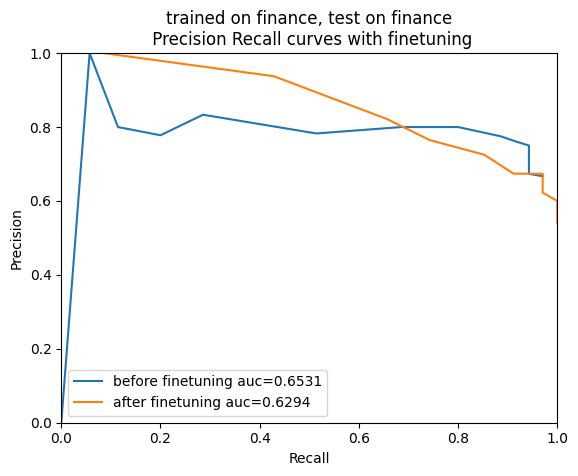

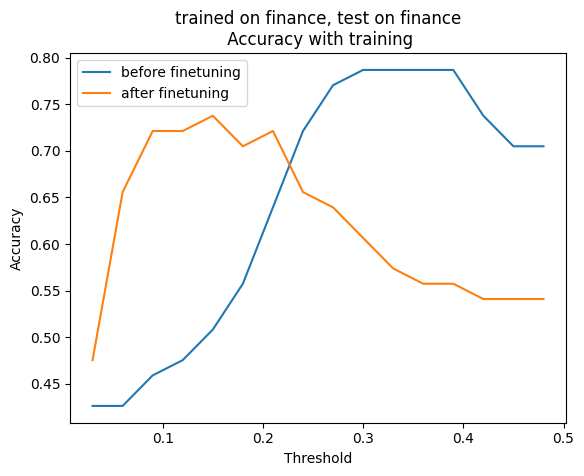

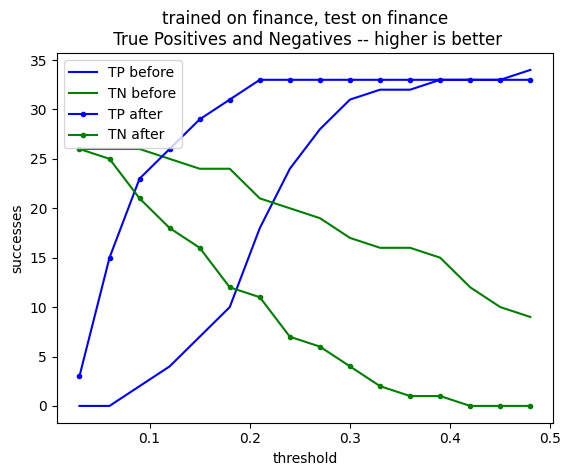

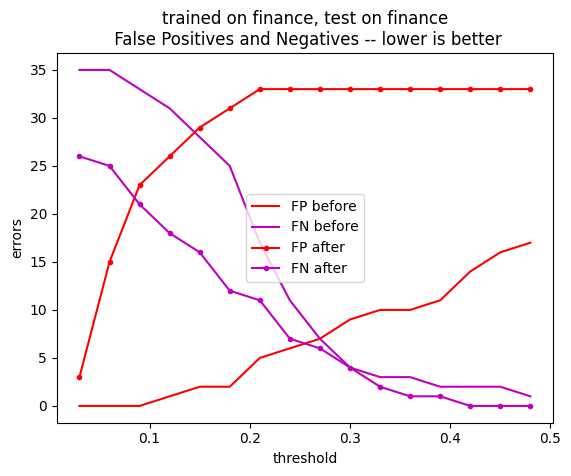

<Figure size 640x480 with 0 Axes>

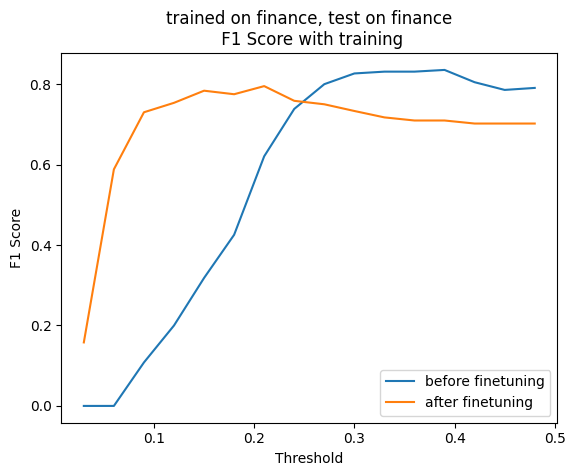

In [86]:
display_AUC(metrics_before_training, metrics_after_training)
display_accuracy(metrics_before_training, metrics_after_training)
display_metrics(metrics_before_training, metrics_after_training)
display_f1_score(metrics_before_training, metrics_after_training)